In [157]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [9]:
# data = pd.read_csv('mbti_1.csv')
df = pd.read_csv('Dataset/mbti_1.csv')
v = df['type'].value_counts()

In [10]:
df['posts'] = df['posts'].str.lower()
df['posts'] = df['posts'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'https\S+', '', regex=True)  #remove URL
df['posts'] = df['posts'].str.replace('\W', ' ', regex=True)
df['posts'] = df['posts'].str.replace('_', ' ', regex=True)
df['posts'] = df['posts'].str.strip()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['posts'] = df['posts'].apply(lambda x: ' '.join([word
   for word in x.split() if word not in (stop_words)
]))

df['posts'] = df['posts'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Kiron\AppData\Local\Temp\ipykernel_27000\87628888.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace('\d+', '')


In [160]:
df.to_csv('mbti_processed.csv', encoding='utf-8', index=False)

In [11]:
nltk.download('punkt')
from nltk import word_tokenize
#df['tokenized'] = nltk.word_tokenize(df['posts'])

from nltk.stem import WordNetLemmatizer
#nltk.download('all', halt_on_error=False)

df['tokenized'] = [word_tokenize(entry) for entry in df['posts']]
nltk.download('wordnet')


def lemmatize(s):
    s = [WordNetLemmatizer().lemmatize(word) for word in s]
    return s

df = df.assign(lemmatized = df.tokenized.apply(lambda x: lemmatize(x)))

df.to_csv('mbt_lemmatized.csv', encoding='utf-8', index=False)
df['lemmatizedstring'] = df['lemmatized'].apply(lambda x: ' '.join(map(str, x)))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kiron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kiron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(df,test_size=0.2,random_state=42,stratify=df.type)

In [13]:
vectorizer=sklearn.feature_extraction.text.TfidfVectorizer( max_features=603,stop_words='english')
vectorizer.fit(train_data.lemmatizedstring)
train_post=vectorizer.transform(train_data.lemmatizedstring).toarray()
test_post=vectorizer.transform(test_data.lemmatizedstring).toarray()

In [14]:
from sklearn.preprocessing import LabelEncoder
target_encoder=LabelEncoder()
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [15]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
train_res,train_target_res= sm.fit_resample(train_post,train_target)
print(train_res)

[[0.         0.07508327 0.04557515 ... 0.0512014  0.10091106 0.        ]
 [0.         0.         0.         ... 0.03099059 0.         0.06158595]
 [0.         0.         0.         ... 0.12570797 0.         0.        ]
 ...
 [0.         0.05311942 0.         ... 0.04182063 0.00754512 0.        ]
 [0.         0.01130907 0.         ... 0.         0.00379981 0.        ]
 [0.02361384 0.01725109 0.03658704 ... 0.         0.         0.        ]]


In [153]:
train_res.shape

(23456, 603)

In [154]:
train_target_res.shape

(23456,)

In [155]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
model_svc=SVC()
model_svc.fit(train_res,train_target_res)
pred_svc=model_svc.predict(test_post)
pred_training_svc=model_svc.predict(train_res)
print("The train accuracy score for model trained on Support Classifier is:",accuracy_score(train_target_res,pred_training_svc))
print("The test accuracy score for model trained on Support Vector classifier is:",accuracy_score(test_target,pred_svc))
from sklearn.metrics import classification_report
personality_types=target_encoder.inverse_transform([i for i in range(16)])
# print('Test classification report of Support Vector Machine\n',classification_report(test_target,model_svc.predict(test_post),target_names=personality))

The train accuracy score for model trained on Support Classifier is: 0.9898533424283765
The test accuracy score for model trained on Support Vector classifier is: 0.6628242074927954


In [156]:
from sklearn.linear_model import LogisticRegression
model_logreg=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_logreg.fit(train_res,train_target_res)
pred_lg=model_logreg.predict(test_post)
pred_training_lg=model_logreg.predict(train_res)
print("The train accuracy score for model trained on Logistic Regression is:",accuracy_score(train_target_res,pred_training_lg))
print("The test accuracy score for model trained on Logistic Regression is:",accuracy_score(test_target,pred_lg))
# print('test classification report \n',sklearn.metrics.classification_report(test_target,model_logreg.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

The train accuracy score for model trained on Logistic Regression is: 0.8799454297407913
The test accuracy score for model trained on Logistic Regression is: 0.6576368876080692


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_res,train_target_res)
pred_nb=model_multinomial_nb.predict(test_post)
pred_training_nb=model_multinomial_nb.predict(train_res)
print("The train accuracy score for model trained on Naive Bayes is:",accuracy_score(train_target_res,pred_training_nb))
print("The test accuracy score for model trained on Naive Bayes is:",accuracy_score(test_target,pred_nb))

The train accuracy score for model trained on Naive Bayes is: 0.8911152796725784
The test accuracy score for model trained on Naive Bayes is: 0.5193083573487032


In [16]:
from xgboost import XGBClassifier
model_xgb=XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.2)
model_xgb.fit(train_res,train_target_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [17]:
pred_xg=model_xgb.predict(test_post)
pred_training_xg=model_xgb.predict(train_res)
print("The train accuracy score for model trained on xgb is:",accuracy_score(train_target_res,pred_training_xg))
print("The test accuracy score for model trained on xgb is:",accuracy_score(test_target,pred_xg))

The train accuracy score for model trained on xgb is: 0.9925392223738063
The test accuracy score for model trained on xgb is: 0.6570605187319885


In [19]:
#print('train classification report \n ',sklearn.metrics.classification_report(train_target_res,model_xgb.predict(train_res),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',sklearn.metrics.classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))


test classification report 
                precision    recall  f1-score   support

        ENFJ       0.51      0.47      0.49        38
        ENFP       0.71      0.64      0.67       135
        ENTJ       0.59      0.41      0.49        46
        ENTP       0.62      0.64      0.63       137
        ESFJ       0.50      0.11      0.18         9
        ESFP       1.00      0.10      0.18        10
        ESTJ       0.50      0.25      0.33         8
        ESTP       0.55      0.33      0.41        18
        INFJ       0.67      0.70      0.68       294
        INFP       0.68      0.73      0.71       366
        INTJ       0.62      0.65      0.64       218
        INTP       0.70      0.74      0.72       261
        ISFJ       0.59      0.48      0.53        33
        ISFP       0.60      0.50      0.55        54
        ISTJ       0.65      0.54      0.59        41
        ISTP       0.61      0.69      0.65        67

    accuracy                           0.66      1

In [1]:
import tensorflow

In [104]:
X_train = np.array(train_res)
X_test = np.array(test_post)

In [105]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [122]:
batch_size = 32
num_classes = 16
epochs = 50
input_shape = (X_train.shape[1], 1)


In [123]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical 
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [124]:
model = Sequential()
intput_shape=(X_train.shape[1], 1)
model.add(Conv1D(64, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(32,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 603, 64)           256       
                                                                 
 batch_normalization_12 (Bat  (None, 603, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 301, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 301, 64)           12352     
                                                                 
 batch_normalization_13 (Bat  (None, 301, 64)          256       
 chNormalization)                                                
                                                      

In [125]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [126]:
Y_train = np.array(train_target_res)
Y_test = np.array(test_target)

In [127]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [128]:
Y_test.shape

(1735, 16)

In [129]:
history=model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,  
          verbose=1,validation_data=(X_test,Y_test))

Epoch 1/50
733/733 [==============================] - 35s 47ms/step - loss: 1.7220 - accuracy: 0.4578 - val_loss: 2.0629 - val_accuracy: 0.4069
Epoch 2/50
733/733 [==============================] - 34s 47ms/step - loss: 1.0047 - accuracy: 0.6784 - val_loss: 1.6279 - val_accuracy: 0.5210
Epoch 3/50
733/733 [==============================] - 34s 46ms/step - loss: 0.8192 - accuracy: 0.7262 - val_loss: 1.5978 - val_accuracy: 0.5470
Epoch 4/50
733/733 [==============================] - 34s 47ms/step - loss: 0.7109 - accuracy: 0.7594 - val_loss: 1.7463 - val_accuracy: 0.5401
Epoch 5/50
733/733 [==============================] - 34s 46ms/step - loss: 0.6316 - accuracy: 0.7825 - val_loss: 1.7263 - val_accuracy: 0.5620
Epoch 6/50
733/733 [==============================] - 34s 46ms/step - loss: 0.5835 - accuracy: 0.8007 - val_loss: 1.9183 - val_accuracy: 0.5493
Epoch 7/50
733/733 [==============================] - 34s 46ms/step - loss: 0.5488 - accuracy: 0.8111 - val_loss: 2.0635 - val_accuracy:

In [88]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

55/55 [==============================] - 4s 74ms/step - loss: 1.8042 - accuracy: 0.5522
Test loss: 1.804225206375122
Test accuracy: 0.5521613955497742


In [89]:
y_pred=model.predict(X_test)
from sklearn.metrics import confusion_matrix
import numpy as np

55/55 [==============================] - 4s 67ms/step


In [21]:
 print(classification_report(Y_test1, y_pred, target_names)

SyntaxError: incomplete input (2734734675.py, line 1)

In [90]:
Y_test1=np.argmax(Y_test, axis=1)

In [91]:
y_pred=np.argmax(y_pred,axis=1)

In [92]:
cmatrix=confusion_matrix(Y_test1, y_pred)

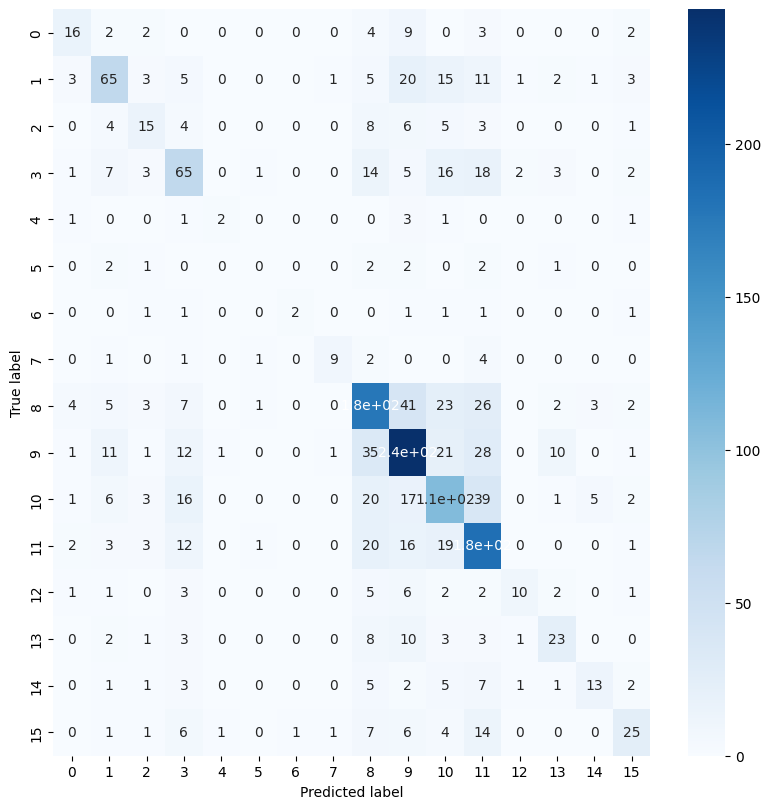

In [98]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

In [23]:
# data = pd.read_csv('mbti_1.csv')
df = pd.read_csv('mbti_1.csv')
v = df['type'].value_counts()

In [24]:
df['posts'] = df['posts'].str.lower()
df['posts'] = df['posts'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'https\S+', '', regex=True)  #remove URL
df['posts'] = df['posts'].str.replace('\W', ' ', regex=True)
df['posts'] = df['posts'].str.replace('_', ' ', regex=True)
df['posts'] = df['posts'].str.strip()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['posts'] = df['posts'].apply(lambda x: ' '.join([word
   for word in x.split() if word not in (stop_words)
]))

df['posts'] = df['posts'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Kiron\AppData\Local\Temp\ipykernel_27000\87628888.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['posts'] = df['posts'].str.replace('\d+', '')


In [25]:
#nltk.download('punkt')
from nltk import word_tokenize

from nltk.stem import WordNetLemmatizer
#nltk.download('all', halt_on_error=False)

df['tokenized'] = [word_tokenize(entry) for entry in df['posts']]
#nltk.download('wordnet')


def lemmatize(s):
    s = [WordNetLemmatizer().lemmatize(word) for word in s]
    return s

df = df.assign(lemmatized = df.tokenized.apply(lambda x: lemmatize(x)))

df['lemmatizedstring'] = df['lemmatized'].apply(lambda x: ' '.join(map(str, x)))

df.to_csv('feature_input.csv')

In [26]:
#Cross Validation - SVM

import pandas as pd
import sklearn
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

#df = pd.read_csv('feature_input.csv')

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer( max_features=603,stop_words='english')
target_encoder=LabelEncoder()
sm = SMOTE(random_state=42)

model_svc=SVC()
kf = KFold(n_splits=10, shuffle=True, random_state=1)

acc_train_score = []
acc_test_score = []


for train_index, test_index in kf.split(df):
    train_data, test_data = df.iloc[train_index, :], df.iloc[test_index, :]

    vectorizer.fit(train_data.lemmatizedstring)
    train_post=vectorizer.transform(train_data.lemmatizedstring).toarray()
    test_post=vectorizer.transform(test_data.lemmatizedstring).toarray()

    train_target=target_encoder.fit_transform(train_data.type)
    test_target=target_encoder.fit_transform(test_data.type)

    train_res,train_target_res= sm.fit_resample(train_post,train_target)

    #model fitting
    model_svc.fit(train_res,train_target_res)
    pred_svc=model_svc.predict(test_post) 
    pred_training_svc=model_svc.predict(train_res)

    acc_train = accuracy_score(train_target_res, pred_training_svc)
    acc_test = accuracy_score(test_target, pred_svc)
    acc_train_score.append(acc_train)
    acc_test_score.append(acc_test)
    print(acc_test_score)

avg_acc_train_score = sum(acc_train_score)/10
avg_acc_test_score = sum(acc_test_score)/10
print("Train accuracy of each fold: {}".format(acc_train_score))
print("Average train accuracy: {}".format(avg_acc_train_score))
print("Test accuracy of each fold: {}".format(acc_test_score))
print("Average test accuracy: {}".format(avg_acc_test_score)) 

[0.6774193548387096]


In [6]:
#Cross Validation - XGB

import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

#df = pd.read_csv('feature_input.csv')

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer( max_features=603,stop_words='english')
target_encoder=LabelEncoder()
sm = SMOTE(random_state=42)

model_xgb = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.2)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

acc_train_score = []
acc_test_score = []


for train_index, test_index in kf.split(df):
    train_data, test_data = df.iloc[train_index, :], df.iloc[test_index, :]

    vectorizer.fit(train_data.lemmatizedstring)
    train_post=vectorizer.transform(train_data.lemmatizedstring).toarray()
    test_post=vectorizer.transform(test_data.lemmatizedstring).toarray()

    train_target=target_encoder.fit_transform(train_data.type)
    test_target=target_encoder.fit_transform(test_data.type)

    train_res,train_target_res= sm.fit_resample(train_post,train_target)

    #model fitting
    model_xgb.fit(train_res,train_target_res)
    pred_xg=model_xgb.predict(test_post) 
    pred_training_xg=model_xgb.predict(train_res)

    acc_train = accuracy_score(train_target_res, pred_training_xg)
    acc_test = accuracy_score(test_target, pred_xg)
    acc_train_score.append(acc_train)
    acc_test_score.append(acc_test)
    print(acc_test_score)

avg_acc_train_score = sum(acc_train_score)/10
avg_acc_test_score = sum(acc_test_score)/10
print("Train accuracy of each fold: {}".format(acc_train_score))
print("Average train accuracy: {}".format(avg_acc_train_score))
print("Test accuracy of each fold: {}".format(acc_test_score))
print("Average test accuracy: {}".format(avg_acc_test_score))

[0.6923963133640553]
[0.6923963133640553, 0.6774193548387096]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.684331797235023]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.684331797235023, 0.6862745098039216]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.684331797235023, 0.6862745098039216, 0.657439446366782]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.684331797235023, 0.6862745098039216, 0.657439446366782, 0.6770472895040369]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.684331797235023, 0.6862745098039216, 0.657439446366782, 0.6770472895040369, 0.621683967704729]
[0.6923963133640553, 0.6774193548387096, 0.6451612903225806, 0.17050691244239632, 0.6843317972

In [7]:
#Cross Validation - NB

import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

#df = pd.read_csv('feature_input.csv')

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer( max_features=603,stop_words='english')
target_encoder=LabelEncoder()
sm = SMOTE(random_state=42)

model_multinomial_nb=MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=1)

acc_train_score = []
acc_test_score = []


for train_index, test_index in kf.split(df):
    train_data, test_data = df.iloc[train_index, :], df.iloc[test_index, :]

    vectorizer.fit(train_data.lemmatizedstring)
    train_post=vectorizer.transform(train_data.lemmatizedstring).toarray()
    test_post=vectorizer.transform(test_data.lemmatizedstring).toarray()

    train_target=target_encoder.fit_transform(train_data.type)
    test_target=target_encoder.fit_transform(test_data.type)

    train_res,train_target_res= sm.fit_resample(train_post,train_target)

    #model fitting
    model_multinomial_nb.fit(train_res,train_target_res)
    pred_nb=model_multinomial_nb.predict(test_post)
    pred_training_nb=model_multinomial_nb.predict(train_res)

    acc_train = accuracy_score(train_target_res,pred_training_nb)
    acc_test = accuracy_score(test_target,pred_nb)
    acc_train_score.append(acc_train)
    acc_test_score.append(acc_test)
    print(acc_test_score)

avg_acc_train_score = sum(acc_train_score)/10
avg_acc_test_score = sum(acc_test_score)/10
print("Train accuracy of each fold: {}".format(acc_train_score))
print("Average train accuracy: {}".format(avg_acc_train_score))
print("Test accuracy of each fold: {}".format(acc_test_score))
print("Average test accuracy: {}".format(avg_acc_test_score))

[0.5737327188940092]
[0.5737327188940092, 0.5852534562211982]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.5610599078341014]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.5610599078341014, 0.5847750865051903]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.5610599078341014, 0.5847750865051903, 0.5628604382929643]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.5610599078341014, 0.5847750865051903, 0.5628604382929643, 0.5651672433679354]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.5610599078341014, 0.5847750865051903, 0.5628604382929643, 0.5651672433679354, 0.5363321799307958]
[0.5737327188940092, 0.5852534562211982, 0.554147465437788, 0.14861751152073732, 0.561059907

In [8]:
#Cross Validation - LR

import pandas as pd
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

#df = pd.read_csv('feature_input.csv')

vectorizer=sklearn.feature_extraction.text.TfidfVectorizer( max_features=603,stop_words='english')
target_encoder=LabelEncoder()
sm = SMOTE(random_state=42)

model_logreg=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

acc_train_score = []
acc_test_score = []


for train_index, test_index in kf.split(df):
    train_data, test_data = df.iloc[train_index, :], df.iloc[test_index, :]

    vectorizer.fit(train_data.lemmatizedstring)
    train_post=vectorizer.transform(train_data.lemmatizedstring).toarray()
    test_post=vectorizer.transform(test_data.lemmatizedstring).toarray()

    train_target=target_encoder.fit_transform(train_data.type)
    test_target=target_encoder.fit_transform(test_data.type)

    train_res,train_target_res= sm.fit_resample(train_post,train_target)

    #model fitting
    model_logreg.fit(train_res,train_target_res)
    pred_lg=model_logreg.predict(test_post)
    pred_training_lg=model_logreg.predict(train_res)

    acc_train = accuracy_score(train_target_res,pred_training_lg)
    acc_test = accuracy_score(test_target,pred_lg)
    acc_train_score.append(acc_train)
    acc_test_score.append(acc_test)
    print(acc_test_score)

avg_acc_train_score = sum(acc_train_score)/10
avg_acc_test_score = sum(acc_test_score)/10
print("Train accuracy of each fold: {}".format(acc_train_score))
print("Average train accuracy: {}".format(avg_acc_train_score))
print("Test accuracy of each fold: {}".format(acc_test_score))
print("Average test accuracy: {}".format(avg_acc_test_score))

[0.6785714285714286]
[0.6785714285714286, 0.6658986175115207]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6647465437788018]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6647465437788018, 0.6828143021914648]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6647465437788018, 0.6828143021914648, 0.6632064590542099]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6647465437788018, 0.6828143021914648, 0.6632064590542099, 0.6701268742791234]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6647465437788018, 0.6828143021914648, 0.6632064590542099, 0.6701268742791234, 0.6424452133794695]
[0.6785714285714286, 0.6658986175115207, 0.6612903225806451, 0.17972350230414746, 0.6